In [15]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [22]:
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 12}

matplotlib.rc('font', **font)

# Measures

In [23]:
#-------Historical Bias-------
def chi_square_test(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    chi2, p, _, _ = chi2_contingency([observed_frequencies, expected_frequencies])
    print(f'Chi-square statistic: {chi2}\np-value: {p}')
    if p < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

def bhattacharyya_coef(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    return round( - np.log(np.sum([np.sqrt(observed_frequencies[i]*expected_frequencies[i]) for i in range(len(expected_frequencies))]) /100 ),3) +0

# Dataset

In [24]:
us_census = pd.read_csv('dataset/us_census.csv')

us_census_1990_race = { 'White':us_census['white'][0]/ us_census['total_population'][0],
                        'Black':us_census['black'][0]/ us_census['total_population'][0],
                        'Native_American':us_census['amer_indian_eskimo'][0]/ us_census['total_population'][0],
                        'Asian_Pac_Islander':us_census['asian_pac_islander'][0]/ us_census['total_population'][0],
                        'Other':us_census['other'][0]/ us_census['total_population'][0],
                        'Two_or_More': 0
}
us_census_2000_race = { 'White':us_census['white'][1]/ us_census['total_population'][1],
                        'Black':us_census['black'][1]/ us_census['total_population'][1],
                        'Native_American':us_census['amer_indian_eskimo'][1]/ us_census['total_population'][1],
                        'Asian_Pac_Islander':us_census['asian_pac_islander'][1]/ us_census['total_population'][1],
                        'Other':us_census['other'][1]/ us_census['total_population'][1],
                        "Two_or_More": us_census["two_or_more"][1]/us_census["total_population"][1]
}
us_census_2020_est_race = { 'White':us_census['white'][4]/ us_census['total_population'][4],
                        'Black':us_census['black'][4]/ us_census['total_population'][4],
                        'Native_American':us_census['amer_indian_eskimo'][4]/ us_census['total_population'][4],
                        'Asian_Pac_Islander':us_census['asian_pac_islander'][4]/ us_census['total_population'][4],
                        'Other':us_census['other'][4]/ us_census['total_population'][4],
                        "Two_or_More": us_census["two_or_more"][4]/us_census["total_population"][4]
}

In [25]:
compas = pd.read_csv('dataset/compas/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv')
compas['Two_yr_Recidivism'] = 1 - compas['Two_yr_Recidivism']
compas.rename(columns={'Two_yr_Recidivism':'No_Two_yr_Recidivism'},inplace=True)
y_class = 'No_Two_yr_Recidivism'
compas['Black_Male'] = np.where( (compas['African_American'] == 1) & (compas['Female'] == 0), 1, 0)
compas['White'] = np.where( (compas['African_American'] == 0) & (compas['Asian'] == 0) & (compas['Hispanic'] == 0) & (compas['Native_American'] == 0) & (compas['Other'] == 0), 1, 0)
#sensible_attribute='African_American'
#privileged_value=0
sensible_attribute='Black_Male'
privileged_value=0
data=compas
dataset_name='Compas'

In [26]:
compas_race = {'White':np.mean(compas['White']),
               'Black':np.mean(compas['African_American']),
               'Native_American':np.mean(compas['Native_American']),
               'Asian_Pac_Islander':np.mean(compas['Asian']),
               'Other':np.mean(compas['Other']) + np.mean(compas['Hispanic']),
               "Two_or_More":0
}

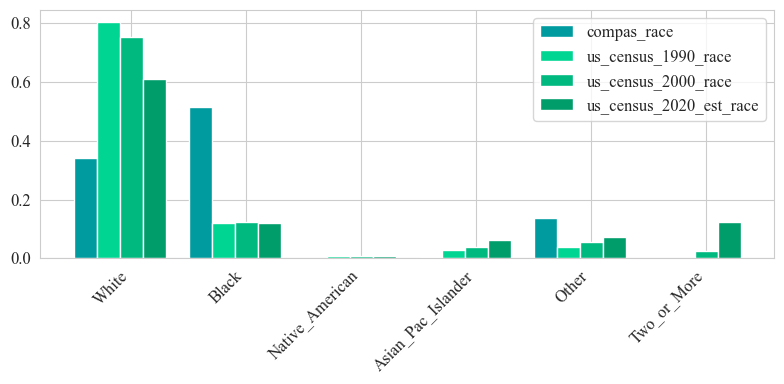

In [27]:
bar_width = 0.2
plt.figure(figsize=(8, 4))
categories = list(compas_race.keys())
ax = plt.subplot(1,1,1)
bar1 = ax.bar(np.arange(len(categories)), list(compas_race.values()), bar_width, label='compas_race', color='#009B9E')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, list(us_census_1990_race.values()), bar_width, label='us_census_1990_race',color='#00D591')
bar3 = ax.bar(np.arange(len(categories)) + 2*bar_width, list(us_census_2000_race.values()), bar_width, label='us_census_2000_race',color='#00B97E')
bar4 = ax.bar(np.arange(len(categories)) + 3*bar_width, list(us_census_2020_est_race.values()), bar_width, label='us_census_2020_est_race',color='#009D6B')
ax.set_xticks(np.arange(len(categories)) + 4*bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(f'plots/bias_dist_{dataset_name}.svg', format='svg')
plt.show()

In [28]:
print("\nCensus 1990")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(compas_race,us_census_1990_race)}')
chi_square_test(compas_race,us_census_1990_race)
print("\nCensus 2000")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(compas_race,us_census_2000_race)}')
chi_square_test(compas_race,us_census_2000_race)
print("\nCensus 2020")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(compas_race,us_census_2020_est_race)}')
chi_square_test(compas_race,us_census_2020_est_race)


Census 1990
Bhattacharyya Coef: 0.149
Chi-square statistic: 50.68264508480232
p-value: 1.0045128057131305e-09
The difference is statistically significant.

Census 2000
Bhattacharyya Coef: 0.148
Chi-square statistic: 48.47108784965283
p-value: 2.8462451456385197e-09
The difference is statistically significant.

Census 2020
Bhattacharyya Coef: 0.189
Chi-square statistic: 51.60082147774111
p-value: 6.513643541970426e-10
The difference is statistically significant.


In [29]:
nlsy = pd.read_csv('dataset/nlsy.csv')

nlsy['grade90'].replace({
    '3RD GRADE': 0,
    '4TH GRADE': 1,
    '5TH GRADE': 2,
    '6TH GRADE': 3,
    '7TH GRADE': 4,
    '8TH GRADE': 5,
    '9TH GRADE': 6,
    '10TH GRADE': 7,
    '11TH GRADE': 8,
    '12TH GRADE': 9,
    '1ST YR COL': 10,
    '2ND YR COL': 11,
    '3RD YR COL': 12,
    '4TH YR COL': 13,
    '5TH YR COL': 14,
    '6TH YR COL': 15,
    '7TH YR COL': 16,
    '8TH YR COL OR MORE': 17
}, inplace=True)

nlsy['gender'].replace({'Female':0, 'Male':1},inplace=True)
nlsy['race'].replace(dict.fromkeys(['AMERICAN','FRENCH','GERMAN','GREEK','ENGLISH','IRISH','ITALIAN','POLISH','PORTUGUESE','RUSSIAN','SCOTTISH','WELSH'],'White'),inplace=True)
nlsy['race'].replace({'BLACK':'Black'},inplace=True)
nlsy['race'].replace(dict.fromkeys(['HAWAIIAN', 'INDIAN', 'FILIPINO', 'KOREAN', 'CHINESE','JAPANESE'],'Asian_Pac_Islander'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['NATIVE-AMERICAN'],'Native_American'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['CUBAN','CHICANO','MEXICAN','MEXICAN-AMERICAN','OTHER-HISPANIC','OTHER-SPANISH','PUERTORICAN'],'Hispanic'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['NONE','OTHER'],'Other'),inplace=True)

nlsy['genhealth'].replace({'Poor': 0,
                           'Fair': 1,
                           'Good': 2,
                           'Very Good': 3,
                           'Excellent': 4},inplace=True)

nlsy['height'] = round(nlsy['height']*0.30)
nlsy['weight'] = round(nlsy['weight']*0.45)
nlsy['jobtrain90'].replace({'No':0,
                            'Yes':1},inplace=True)

data = nlsy.drop(['id','income96'],axis=1)
enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == "object":
        data[i]=enc.fit_transform(data[i])
#nlsy['age'] = pd.cut(nlsy['age'],4, labels=[0,1,2,3])
y_class = 'income96gt17'
sensible_attribute='gender'
privileged_value=1
dataset_name = 'nlsy'

In [30]:
nlsy_race = {'White': (nlsy.loc[ (nlsy["race"] == "White")  ].shape[0]) / nlsy.shape[0],
             'Black': (nlsy.loc[ (nlsy["race"] == "Black")  ].shape[0]) / nlsy.shape[0],
             'Native_American': (nlsy.loc[ (nlsy["race"] == "Native_American")  ].shape[0]) / nlsy.shape[0],
             'Asian_Pac_Islander': (nlsy.loc[ (nlsy["race"] == "Asian_Pac_Islander")  ].shape[0]) / nlsy.shape[0],
             'Other': (nlsy.loc[ (nlsy["race"] == "Other") | (nlsy["race"] == "Hispanic")  ].shape[0]) / nlsy.shape[0],
             'Two_or_More':0
}

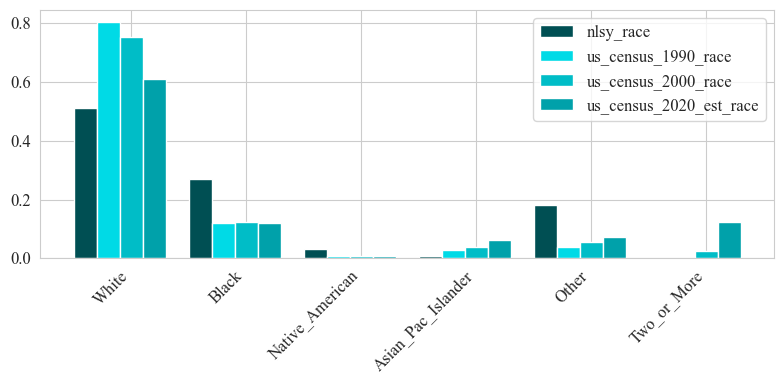

In [31]:
bar_width = 0.2
plt.figure(figsize=(8, 4))
categories = list(nlsy_race.keys())
ax = plt.subplot(1,1,1)
bar1 = ax.bar(np.arange(len(categories)), list(nlsy_race.values()), bar_width, label='nlsy_race', color='#004F53')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, list(us_census_1990_race.values()), bar_width, label='us_census_1990_race',color='#00DAE6')
bar3 = ax.bar(np.arange(len(categories)) + 2*bar_width, list(us_census_2000_race.values()), bar_width, label='us_census_2000_race',color='#00BDC7')
bar4 = ax.bar(np.arange(len(categories)) + 3*bar_width, list(us_census_2020_est_race.values()), bar_width, label='us_census_2020_est_race',color='#00A1AA')
ax.set_xticks(np.arange(len(categories)) + 4*bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(f'plots/bias_dist_{dataset_name}.svg', format='svg')
plt.show()

In [32]:
print("\nCensus 1990")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(nlsy_race,us_census_1990_race)}')
chi_square_test(nlsy_race,us_census_1990_race)
print("\nCensus 2000")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(nlsy_race,us_census_2000_race)}')
chi_square_test(nlsy_race,us_census_2000_race)
print("\nCensus 2020")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(nlsy_race,us_census_2020_est_race)}')
chi_square_test(nlsy_race,us_census_2020_est_race)


Census 1990
Bhattacharyya Coef: 0.066
Chi-square statistic: 23.92780402784522
p-value: 0.00022415923610609546
The difference is statistically significant.

Census 2000
Bhattacharyya Coef: 0.068
Chi-square statistic: 22.498388225362845
p-value: 0.0004208430664135614
The difference is statistically significant.

Census 2020
Bhattacharyya Coef: 0.113
Chi-square statistic: 28.79991199654994
p-value: 2.5380158891436003e-05
The difference is statistically significant.


In [33]:
adult = pd.read_csv('dataset/adult.csv')
adult['income'] = adult['income'].replace('<=50K',0).replace('>50K',1)
adult['sex'].replace({'Female':0, 'Male':1})
data = adult.drop(['education','fnlwgt'], axis=1)
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)

adult_race = { "White":              (adult.loc[ (adult["race"] == "White")  ].shape[0]) / adult.shape[0],
               "Black":              (adult.loc[ (adult["race"] == "Black")].shape[0]) / adult.shape[0],
               "Asian-Pac-Islander": (adult.loc[ (adult["race"] == "Asian-Pac-Islander")].shape[0]) / adult.shape[0],
               "Amer-Indian-Eskimo": (adult.loc[ (adult["race"] == "Amer-Indian-Eskimo")].shape[0]) / adult.shape[0],
               "Other":              (adult.loc[ (adult["race"] == "Other")].shape[0]) / adult.shape[0],
               "Two_or_More": 0
}
enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i]=enc.fit_transform(data[i])

y_class='income'

sensible_attribute = 'sex'
privileged_value=1
dataset_name='adult'

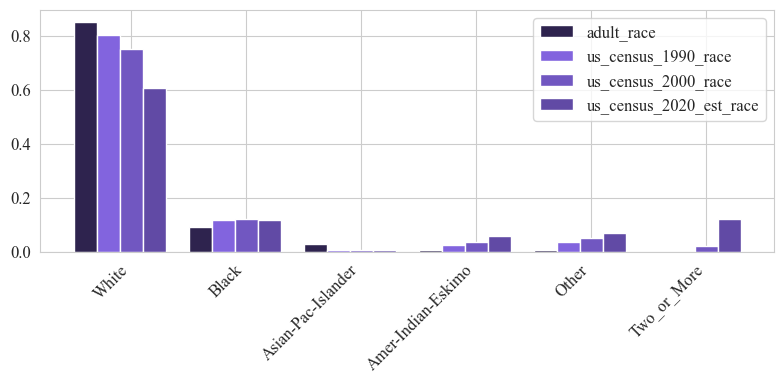

In [34]:
bar_width = 0.2
plt.figure(figsize=(8, 4))
categories = list(adult_race.keys())
ax = plt.subplot(1,1,1)
bar1 = ax.bar(np.arange(len(categories)), list(adult_race.values()), bar_width, label='adult_race', color='#2E234E')
bar2 = ax.bar(np.arange(len(categories)) + bar_width, list(us_census_1990_race.values()), bar_width, label='us_census_1990_race',color='#8264DE')
bar3 = ax.bar(np.arange(len(categories)) + 2*bar_width, list(us_census_2000_race.values()), bar_width, label='us_census_2000_race',color='#7157C1')
bar4 = ax.bar(np.arange(len(categories)) + 3*bar_width, list(us_census_2020_est_race.values()), bar_width, label='us_census_2020_est_race',color='#614AA5')
ax.set_xticks(np.arange(len(categories)) + 4*bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(f'plots/bias_dist_{dataset_name}.svg', format='svg')
plt.show()

In [35]:
print("\nCensus 1990")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(adult_race,us_census_1990_race)}')
chi_square_test(adult_race,us_census_1990_race)
print("\nCensus 2000")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(adult_race,us_census_2000_race)}')
chi_square_test(adult_race,us_census_2000_race)
print("\nCensus 2020")
print(f'Bhattacharyya Coef: {bhattacharyya_coef(adult_race,us_census_2020_est_race)}')
chi_square_test(adult_race,us_census_2020_est_race)


Census 1990
Bhattacharyya Coef: 0.014
Chi-square statistic: 4.916386529448661
p-value: 0.4261695730924996
The difference is not statistically significant.

Census 2000
Bhattacharyya Coef: 0.034
Chi-square statistic: 9.822532808071797
p-value: 0.08042273327296987
The difference is not statistically significant.

Census 2020
Bhattacharyya Coef: 0.11
Chi-square statistic: 27.09860960859584
p-value: 5.4574743326423684e-05
The difference is statistically significant.
